In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import re
import json

import evaluate
import torch
from torch.utils.data import Dataset, DataLoader

from transformers import (
    AutoModelForSequenceClassification, 
    AutoTokenizer,
    AutoModelForCausalLM
)
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Seed Set
SEED = 456
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

# 디바이스 설정 (GPU가 사용 가능하면 GPU를 사용하고, 그렇지 않으면 CPU 사용)
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [59]:
data_path = os.path.join("..","..","data","v0.1","train_Label_noise_data_ascii.csv")
data = pd.read_csv(data_path)
data = data.drop(columns=["Unnamed: 0"])
data

,ID,text,target,ascii_counts,non_ascii_counts,ratio
0,ynat-v1_train_00003,갤노트8 주말 27만대 개통…시장은 불법 보조금 얼룩,5,3,26,10.34
1,ynat-v1_train_00005,美성인 6명 중 1명꼴 배우자·연인 빚 떠안은 적 있다,0,2,28,6.67
2,ynat-v1_train_00007,아가메즈 33득점 우리카드 KB손해보험 완파…3위 굳...,4,8,24,25.00
3,ynat-v1_train_00008,朴대통령 얼마나 많이 놀라셨어요…경주 지진현장 방문종합,6,0,30,0.00
4,ynat-v1_train_00009,듀얼심 아이폰 하반기 출시설 솔솔…알뜰폰 기대감,4,0,26,0.00
...,...,...,...,...,...,...
1499,ynat-v1_train_02794,문 대통령 김기식 금감원장 사표 수리키로종합,2,0,24,0.00
1500,ynat-v1_train_02795,트럼프 폭스뉴스 앵커들 충성도 점수매겨…10점만점에 12점도,6,4,29,12.12
1501,ynat-v1_train_02796,삼성 갤럭시S9 정식 출시 첫 주말 이통시장 잠잠,2,2,25,7.41
1502,ynat-v1_train_02798,인터뷰 류현진 친구에게 안타 맞는 것 싫어해…승부는 냉정,1,0,31,0.00


# SentenceBERT with Kmeans

In [111]:
# Sentence BERT를 이용한 KMeans Clustering
from sentence_transformers import SentenceTransformer
#"snunlp/KR-SBERT-Medium-extended-patent2024-hn"
#"jhgan/ko-sroberta-multitask"
model_path = "sinjy1203/ko-sbert-navernews" # most likes
model = SentenceTransformer(model_path)

In [112]:
corpus_embeddings = model.encode(data["text"])
corpus_embeddings.shape

(1504, 768)

In [124]:
from sklearn.cluster import KMeans
k = 3
kmeans = KMeans(n_clusters=7, random_state=456).fit(corpus_embeddings)
cls_dist=pd.Series(kmeans.labels_).value_counts()

In [125]:
cls_dist

6    375
3    255
2    247
5    226
0    185
1    160
4     56
Name: count, dtype: int64

In [126]:
import matplotlib.pyplot as plt
import umap
import scipy

In [127]:
distances = scipy.spatial.distance.cdist(kmeans.cluster_centers_,corpus_embeddings)
centers={}
print("Cluster", "Size", "Center-idx","Center-Example", sep="\t\t")
for i,d in enumerate(distances):
    ind = np.argsort(d, axis=0)[0]
    centers[i]=ind
    print(i,cls_dist[i], ind, data["text"][ind] ,sep="\t\t")

Cluster		Size		Center-idx		Center-Example
0		185		276		11월 주식 발행액 전월비 60% 증가…IPO·유상증자↑
1		160		632		朴대통령 국회가 법막고 -떻oj,민지X 호소하$가종합
2		247		135		임도헌 감독 젊은 선수들 자신감 얻었다…내년 1월 진짜 승부
3		255		163		아랍권 반D란"정상회의 5춰 (\s& 이란 맹9종합
4		56		637		충북 말복 더위 지속…강한 소나기 주의
5		226		1095		이통Y사f갤럭시탭Sr 오늘w터L사전예약 시작
6		375		1037		백낙청이 말하는 더 나은 세상…회화록 6∼7권 출간


[5 6 2 ... 5 2 5]
[18.564224  12.88884    1.6428605 ... 18.462502  -1.1867388 16.778566 ]


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.10/site-packages/matplotlib/pyplot.py'>

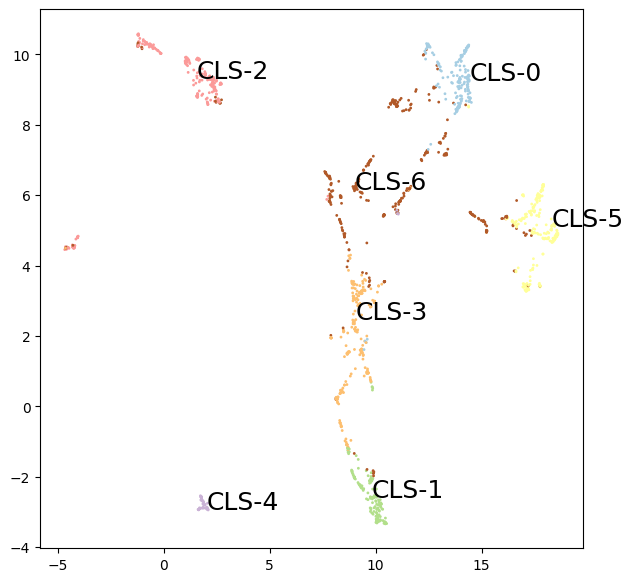

In [128]:
X = umap.UMAP(n_components=2, min_dist=0.0).fit_transform(corpus_embeddings)
labels = kmeans.labels_
print(labels)
fig, ax = plt.subplots(figsize=(7,7))

print(X[:,0])
plt.scatter(X[:,0], X[:,1], c=labels, s=1, cmap="Paired")

for c in centers:
    plt.text(X[centers[c], 0], X[centers[c],1], "CLS-"+str(c), fontsize=18)
plt

In [129]:
# post processing
# 노이즈가 적은 데이터 중에 label들을 모아서 해당 하는 인덱스의 라벨대로 다 바꿔주는 것
data = data[["ID","text","target","ratio"]]
label0 = data[data["target"] == 0]
label1 = data[data["target"] == 1]
label2 = data[data["target"] == 2]
label3 = data[data["target"] == 3]
label4 = data[data["target"] == 4]
label5 = data[data["target"] == 5]
label6 = data[data["target"] == 6]

In [130]:
noise_0 = label0[label0["ratio"]>25].iloc[1]["ID"]
noise_1 = label1[label1["ratio"]>25].iloc[1]["ID"]
noise_2 = label2[label2["ratio"]>25].iloc[0]["ID"]
noise_3 = label3[label3["ratio"]>25].iloc[0]["ID"]
noise_4 = label4[label4["ratio"]>25].iloc[0]["ID"]
noise_5 = label5[label5["ratio"]>25].iloc[0]["ID"]
noise_6 = label6[label6["ratio"]>25].iloc[0]["ID"]

In [131]:
data["relabeled"] = kmeans.labels_
print(data[data["ID"]==noise_0]["relabeled"])
print(data[data["ID"]==noise_1]["relabeled"])
print(data[data["ID"]==noise_2]["relabeled"])
print(data[data["ID"]==noise_3]["relabeled"])
print(data[data["ID"]==noise_4]["relabeled"])
print(data[data["ID"]==noise_5]["relabeled"])
print(data[data["ID"]==noise_6]["relabeled"])

60    4
Name: relabeled, dtype: int32
184    2
Name: relabeled, dtype: int32
35    1
Name: relabeled, dtype: int32
14    6
Name: relabeled, dtype: int32
65    5
Name: relabeled, dtype: int32
188    0
Name: relabeled, dtype: int32
163    3
Name: relabeled, dtype: int32


각 라벨에 해당하는 noise 데이터들이 겹치지 않는 것을 확인  
따라서 다음과 같이 라벨을 mapping  
4 -> 0  
2 -> 1  
1 -> 2  
6 -> 3  
5 -> 4  
0 -> 5  
3 -> 6  

In [135]:
def transform_values(input_list):
    # 매핑 딕셔너리 정의
    mapping = {
        4: 0,
        2: 1,
        1: 2,
        6: 3,
        5: 4,
        0: 5,
        3: 6
    }
    
    # 입력 리스트의 각 요소를 매핑 딕셔너리를 사용해 변환
    transformed_list = [mapping.get(value, value) for value in input_list]
    return transformed_list
relabeled_mapping_list = transform_values(kmeans.labels_)
cls_dist_re=pd.Series(relabeled_mapping_list).value_counts()
print(cls_dist_re)
print(cls_dist)

3    375
6    255
1    247
4    226
5    185
2    160
0     56
Name: count, dtype: int64
6    375
3    255
2    247
5    226
0    185
1    160
4     56
Name: count, dtype: int64


In [136]:
data["relabeled"] = relabeled_mapping_list

In [141]:
out_csv = data[["ID","text","relabeled"]]
out_csv.rename(columns={"relabeled":"target"}, inplace=True)
out_csv.to_csv(os.path.join("..","..","data","v0.1","relabeled_using_SBERT.csv"),encoding="utf-8-sig")

/tmp/ipykernel_1022090/388443149.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_csv.rename(columns={"relabeled":"target"}, inplace=True)


# CleanLab

CleanLab을 사용해서 Label Noise 검사